In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
from scipy.linalg import sqrtm
from torchsummary import summary
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from h5py import File as HDF5File
%matplotlib inline
import torch.nn as nn
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import tensorflow as tf
from scipy.stats import norm
from scipy.stats import gaussian_kde

2025-07-03 17:33:57.924555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 17:33:57.965260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-03 17:33:57.965294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-03 17:33:57.966232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 17:33:57.972761: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
images_path = '../data/QCDToGGQQ_IMGjet_combined.h5'
quark_gluon_data = HDF5File(images_path, 'r')

print(quark_gluon_data.keys())
print(quark_gluon_data['X_jets'].shape)
print(quark_gluon_data['m0'].shape)
print(quark_gluon_data['pt'].shape)
print(quark_gluon_data['y'].shape)

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
(139306, 3, 125, 125)
(139306, 1)
(139306, 1)
(139306, 1)


In [24]:
def plot_generated_samples(generator, kdes, batch_size=4, latent_dim=625):
    generator.eval()  # Disable dropout/batchnorm updates

    # Latent vectors and codings
    z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
    z_codings = torch.cat([
        torch.randint(0, 2, (batch_size, 1)), 
        sample_fit_noise(kdes, num_samples=batch_size)
    ], dim=1).cuda()

    with torch.no_grad():
        gen_samples = generator(z_codings).cpu()  # Shape: (B, 3, 25, 25)

    print("Generated sample shape:", gen_samples.shape)
    print("Sample feature coding:", np.round(z_codings[0].cpu().numpy(), 4))

    # Plot: 3 rows (channels) x batch_size columns
    fig, axes = plt.subplots(nrows=3, ncols=batch_size, figsize=(batch_size * 1.5, 4.5))
    channel_titles = ['Layer 1', 'Layer 2', 'Layer 3']

    for b in range(batch_size):
        for c in range(3):
            ax = axes[c, b]
            ax.imshow(gen_samples[b, c].numpy(), cmap='viridis', vmin=0, vmax=1)
            ax.axis('off')
            if b == 0:
                ax.set_ylabel(channel_titles[c], fontsize=10)

    plt.tight_layout()
    plt.suptitle("Generated Jet Images", fontsize=14, y=1.02)
    plt.show()

    generator.train()  # Restore training mode
    
def plot_metrics(g_losses, d_losses):
    epochs = range(1, len(g_losses) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, g_losses, label='Generator Loss', color='blue')
    plt.plot(epochs, d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_nonzero_pixel_distributions(images):
    """
    images: torch.Tensor of shape (N, 3, 25, 25)
    """
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    colors = ['red', 'green', 'blue']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for c in range(3):
        pixels = images[:, c, :, :].flatten()
        nonzero_pixels = pixels[pixels != 0]
        axes[c].hist(nonzero_pixels, bins=10000, color=colors[c], alpha=0.75, edgecolor='black')
        axes[c].set_title(f'Non-zero Pixel Values — {channel_names[c]}')
        axes[c].set_xlabel('Value')
        axes[c].set_ylabel('Count')
        axes[c].grid(True)
    axes[0].set_xlim(left=-.5, right=10)
    axes[1].set_xlim(left=-.5, right=1)
    axes[2].set_xlim(left=-.5, right=1)

    plt.tight_layout()
    plt.show()

def plot_outlier_pixel_distributions(images):
    """
    images: torch.Tensor of shape (N, 3, 25, 25)
    """
    channel_names = ['Channel 1 Outliers', 'Channel 2 Outliers', 'Channel 3 Outliers']
    colors = ['red', 'green', 'blue']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for c in range(3):
        pixels = images[:, c, :, :].flatten()
        nonzero_pixels = pixels[pixels != 0]
        axes[c].hist(nonzero_pixels, bins=10000, color=colors[c], alpha=0.75, edgecolor='black')
        axes[c].set_title(f'Non-zero Pixel Values — {channel_names[c]}')
        axes[c].set_xlabel('Value')
        axes[c].set_ylabel('Count')
        axes[c].grid(True)

    axes[0].set_xlim(left=100)
    axes[1].set_xlim(left=20)
    axes[2].set_xlim(left=1)
    axes[0].set_ylim(top=100)
    axes[1].set_ylim(top=100)
    axes[2].set_ylim(top=100)

    plt.tight_layout()
    plt.show()

def plot_min_pixel_distributions(images):
    fig, axis = plt.subplots(1, 1, figsize=(18, 5))

    min_pixels = []
    for c in range(3):
        pixels = images[:, c, :, :]
        min_pixels.append(np.min(pixels, axis=(1, 2)))

    axis.hist(np.concatenate(min_pixels), bins=1000, alpha=0.75, edgecolor='black')
    axis.set_title(f'Minimum Pixel Values')
    axis.set_xlabel('Value')
    axis.set_ylabel('Count')
    axis.grid(True)
    axis.set_ylim(top=100)
    plt.tight_layout()
    plt.show()

In [5]:
## Helper Functions for kde distributions, noise, loss, etc
def feature_distributions(dataset, x_max=None, bw_method='scott'):
    all_features = torch.stack([dataset[i][1] for i in range(len(dataset))])

    kde_labels = [
        "y", "m0", "pt",
        "dR1_mean", "dR2_mean", "dR3_mean",
        "dR1_std", "dR2_std", "dR3_std",
        "pix1_mean", "pix2_mean", "pix3_mean",
        "pix1_std", "pix2_std", "pix3_std"
    ]

    feature_labels = [
        r"$y$", r"$m_0$", r"$p_T$",
        r"$\langle \Delta R_1 \rangle$", r"$\langle \Delta R_2 \rangle$", r"$\langle \Delta R_3 \rangle$",
        r"$\sigma_{\Delta R_1}$", r"$\sigma_{\Delta R_2}$", r"$\sigma_{\Delta R_3}$",
        r"$\langle \mathrm{Pix}_1 \rangle$", r"$\langle \mathrm{Pix}_2 \rangle$", r"$\langle \mathrm{Pix}_3 \rangle$",
        r"$\sigma_{\mathrm{Pix}_1}$", r"$\sigma_{\mathrm{Pix}_2}$", r"$\sigma_{\mathrm{Pix}_3}$"
    ]
    
    single_features = [
        (0, r"$y$"),
        (1, r"$m_0$"),
        (2, r"$p_T$")
    ]

    grouped_features = [
        ([3,4,5], r"$\langle \Delta R \rangle$"),
        ([6,7,8], r"$\sigma_{\Delta R}$"),
        ([9,10,11], r"$\langle \mathrm{Pix} \rangle$"),
        ([12,13,14], r"$\sigma_{\mathrm{Pix}}$")
    ]

    n_single = len(single_features)
    n_grouped = len(grouped_features)
    ncols = 3
    nrows = (n_single + n_grouped + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axs = axs.flatten()

    # Get x_max for plot i
    def get_xmax(i, default=None):
        if x_max is None:
            return default
        if isinstance(x_max, (list, tuple, np.ndarray)):
            if i < len(x_max):
                return x_max[i]
            else:
                return default
        return x_max  # scalar

    kde_fits = {}

    # Plot single features
    for idx, (feat_idx, label) in enumerate(single_features):
        data = all_features[:, feat_idx].cpu().numpy()
        mean_val = data.mean()
        std_val = data.std()

        axs[idx].hist(data, bins=100, alpha=0.4, color='skyblue', edgecolor='black', density=True)
        kde = gaussian_kde(data, bw_method)
        kde_fits[kde_labels[feat_idx]] = kde
        
        x_vals = np.linspace(data.min(), data.max(), 500)
        axs[idx].plot(x_vals, kde(x_vals), label='KDE', color='green')

        xmax = get_xmax(idx, default=data.max())
        if xmax is not None:
            axs[idx].set_xlim(right=xmax)
        axs[idx].set_ylim(bottom=0)
        
        axs[idx].set_title(label, fontsize=14)
        axs[idx].set_xlabel(label)
        axs[idx].set_ylabel("Density")
        axs[idx].grid(True)
        axs[idx].legend()

    colors = ['red', 'green', 'blue']
    layer_labels = ['Layer 1', 'Layer 2', 'Layer 3']

    # Plot grouped features with overlay
    for j, (indices, base_label) in enumerate(grouped_features):
        ax_idx = n_single + j
        ax = axs[ax_idx]

        max_val = None
        for i, feat_idx in enumerate(indices):
            data = all_features[:, feat_idx].cpu().numpy()
            mean_val = data.mean()
            std_val = data.std()

            bins = 500 if feat_idx % 3 == 0 else 250

            counts, bins, _ = ax.hist(data, bins=bins, alpha=0.3, color=colors[i], edgecolor='black', density=True, label=f'{layer_labels[i]}')
            kde = gaussian_kde(data, bw_method)
            kde_fits[kde_labels[feat_idx]] = kde
            x_vals = np.linspace(bins[0], bins[-1], 500)
            ax.plot(x_vals, kde(x_vals), color=colors[i], lw=2)

            max_val = max(max_val or 0, data.max())

        xmax = get_xmax(ax_idx, default=max_val)
        if xmax is not None:
            ax.set_xlim(right=xmax)

        ax.set_title(base_label, fontsize=14)
        ax.set_xlabel(base_label)
        ax.set_ylabel("Density")
        ax.grid(True)
        ax.legend()

    for k in range(n_single + n_grouped, len(axs)):
        axs[k].axis('off')

    plt.tight_layout()
    plt.suptitle("Feature Distributions with Overlaid Detector Layers", fontsize=16, y=1.02)
    plt.show()

    return kde_fits

def sample_fit_noise(kde_fits, num_samples=1):
    feature_labels = [
        "m0", "pt",
        "dR1_mean", "dR2_mean", "dR3_mean",
        "dR1_std", "dR2_std", "dR3_std",
        "pix1_mean", "pix2_mean", "pix3_mean",
        "pix1_std", "pix2_std", "pix1_std"
    ]

    samples = []
    for label in feature_labels:
        kde = kde_fits[label]
        sampled = kde.resample(num_samples).T.squeeze()
        samples.append(sampled)

    stacked = np.stack(samples, axis=1)  # shape (num_samples, 15)
    return torch.tensor(stacked, dtype=torch.float32)

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach

    def forward(self, x):
        if self.training and self.sigma > 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = torch.randn_like(x) * scale
            return x + sampled_noise
        return x

def kde_kl_divergence_torch(real, fake, bandwidth=0.1, num_points=1000, eps=1e-8):
    min_val = torch.min(real.min(), fake.min()).detach()
    max_val = torch.max(real.max(), fake.max()).detach()
    support = torch.linspace(min_val, max_val, num_points, device=real.device).view(1, -1)  # [1, num_points]

    def kde(samples):
        # [B, 1] - expand to [B, num_points] for distance to each x
        samples = samples.view(-1, 1)
        dists = (samples - support) ** 2  # [B, num_points]
        kernels = torch.exp(-0.5 * dists / bandwidth**2)
        pdf = kernels.sum(dim=0)  # sum over samples -> [num_points]
        pdf /= (pdf.sum() + eps)  # normalize
        return pdf + eps  # avoid log(0)

    p = kde(real)
    q = kde(fake)

    kl = (p * (p.log() - q.log())).sum()
    return kl

def max_per_channel(max_val, x: torch.Tensor) -> torch.Tensor:
    x_perm = x.permute(1, 0, 2, 3)
    x_flat = x_perm.reshape(x_perm.size(0), -1)
    x_flat = x_flat.detach().cpu().numpy()
    # q3 = torch.quantile(x_flat, 0.99, dim=1)   # (C, 1)
    q3 = np.quantile(x_flat, max_val, axis=1)   # (C, 1)
    q3 = torch.from_numpy(q3)
    
    return q3.unsqueeze(1).unsqueeze(1).unsqueeze(0)
    
def min_per_channel(min_val, x: torch.Tensor) -> torch.Tensor:
    x_flat = x.reshape(x.size(0)*x.size(1), -1)
    x_flat = x_flat.detach().cpu().numpy()
    # q3 = torch.quantile(x_flat, 0.01, dim=1)   # (C, 1)
    q3 = np.quantile(x_flat, min_val, axis=1)   # (C, 1)
    q3 = torch.from_numpy(q3)

    return q3.view(x.size(0), 3, 1, 1)

def MaxReLU(x):
    return torch.minimum(x, torch.tensor(1))

In [6]:
class JetDataset(Dataset):
    def __init__(self, data, n_events):

        self.images = torch.tensor(data['X_jets'][:n_events])
        self.images = self.images[:,:,11:112, 11:112]
        self.images = F.avg_pool2d(self.images, kernel_size=4, stride=4)        
        self.flipped_images = torch.flip(self.images,[2])

        print(f"Images Shape: {self.images.shape}")

        # Normalize each channel
        Min = self.images.amin(dim=(2,3), keepdim = True)
        Max = self.images.amax(dim=(2,3), keepdim = True)
        # Min = min_per_channel(.9, self.images)
        # Max = max_per_channel(.995, self.images)

        print(Min.shape)
        print(Max.shape)

        self.images = (self.images - Min) / (Max - Min)
        self.flipped_images = (self.flipped_images - Min) /(Max - Min)

        self.images[self.images > 1] = 1
        self.flipped_images[self.flipped_images > 1] = 1
        # self.images[self.images < 0] = 0
        # self.flipped_images[self.flipped_images < 0] = 0

        # self.images = torch.clamp(self.images, min=Min, max=Max)
        # self.flipped_images = torch.clamp(self.flipped_images, min=Min, max=Max)

        # ----- ΔR Calculation -----
        # Image shape: (25, 25)
        N, C, H, W = self.images.shape
        center_x, center_y = (W - 1) / 2, (H - 1) / 2

        # Coordinate grid
        x_coords, y_coords = torch.meshgrid(
            torch.arange(W, dtype=torch.float32),
            torch.arange(H, dtype=torch.float32),
            indexing='ij'
        )

        # Distance from center
        dists = torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)
        dists = dists.unsqueeze(0).unsqueeze(0)  # [1, 1, 25, 25]
        print(f"Distance Shape: {dists.shape}")
        # Weighted: sum(pixel * distance) / sum(pixel)
        weights = self.images
        weight_norm = torch.amax(self.images, dim=(2,3), keepdim=True)
        
        print(f"Weight Shape: {weights.shape}")
        dR = (weights * dists) / weight_norm

        # Compute per-image (channel) ΔR stats: output [N, C]
        dR = (self.images * dists) / weight_norm
        dR_mean = dR.view(N, C, -1).mean(dim=2)
        dR_std = dR.view(N, C, -1).std(dim=2)
        
        # Pixel stats: per image channel
        pixel_mean = self.images.view(N, C, -1).mean(dim=2)
        pixel_std = self.images.view(N, C, -1).std(dim=2)

        print(f"dR Mean: {dR_mean.shape}")
        print(f"dR STD: {dR_std.shape}")
        print(f"Pixel Mean: {pixel_mean.shape}")
        print(f"Pixel STD: {pixel_std.shape}")

        print("pt:", data['pt'][:n_events].shape)
        print("m0:", data['m0'][:n_events].shape)
        print("y:", data['y'][:n_events].shape)

        self.features = torch.tensor(np.concatenate([
            data['y'][:n_events],
            data['m0'][:n_events],
            data['pt'][:n_events],
            dR_mean,
            dR_std,
            pixel_mean,
            pixel_std
        ], axis=1), dtype=torch.float32)

        print("Feature shape per event:", self.features.shape)

        # Normalize pt and mass features here also
        # Normalize jet_mass (index 1)
        self.features[:, 1] = (self.features[:, 1]-self.features[:, 1].min()) / (self.features[:, 1].max()-self.features[:, 1].min())
        # Normalize jet_pt (index 2)
        self.features[:, 2] = (self.features[:, 2]-self.features[:, 2].min()) / (self.features[:, 2].max()-self.features[:, 2].min())
        
        print("ΔR min:", dR.min().item())
        print("ΔR max:", dR.max().item())
        
        print("ΔR mean min:", dR_mean.min().item())
        print("ΔR mean max:", dR_mean.max().item())
        
        print("ΔR std min:", dR_std.min().item())
        print("ΔR std max:", dR_std.max().item())
        
        print("Weights (pixel intensity) min:", weights.min().item())
        print("Weights (pixel intensity) max:", weights.max().item())
        
        print("Pixel mean min:", pixel_mean.min().item())
        print("Pixel mean max:", pixel_mean.max().item())
        
        print("Pixel std min:", pixel_std.min().item())
        print("Pixel std max:", pixel_std.max().item())


    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.images[idx]
        features = self.features[idx]
        flipped_image = self.flipped_images[idx]

        return image, features, flipped_image

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=25*25):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.1)

        self.feature_gen = nn.Sequential(
            nn.Linear(15, 64),
            nn.ReLU(),
            nn.Linear(64, 25*25),
            nn.LayerNorm(25*25),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(25*25, 256, kernel_size=4, stride=1, padding=0),
            nn.LayerNorm(256),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LayerNorm(128),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LayerNorm(64),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LayerNorm(32),
            nn.ReLU(),
        )
        
        self.image_gen5 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, padding=0),
            nn.LayerNorm(16),
            nn.ReLU(),
        )
        
        self.image_gen6 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=6, stride=1, padding=0),
            nn.LayerNorm(3),
            nn.ReLU(),
        )


    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        img = img.view(-1, 625, 1, 1)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = self.image_gen5(img)
        # print(img.shape)
        img = self.image_gen6(img)
        # print(img.shape)
        img = MaxReLU(img)
        
        # threshold = 0.001
        # img = torch.where(img < threshold, torch.tensor(0.0, device=img.device), img)

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 25*25 = 625
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 25, 25)
            flat_dim = self.image_encoder(dummy).shape[1] + 64
            
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
(139306, 3, 125, 125)
(139306, 1)
(139306, 1)
(139306, 1)


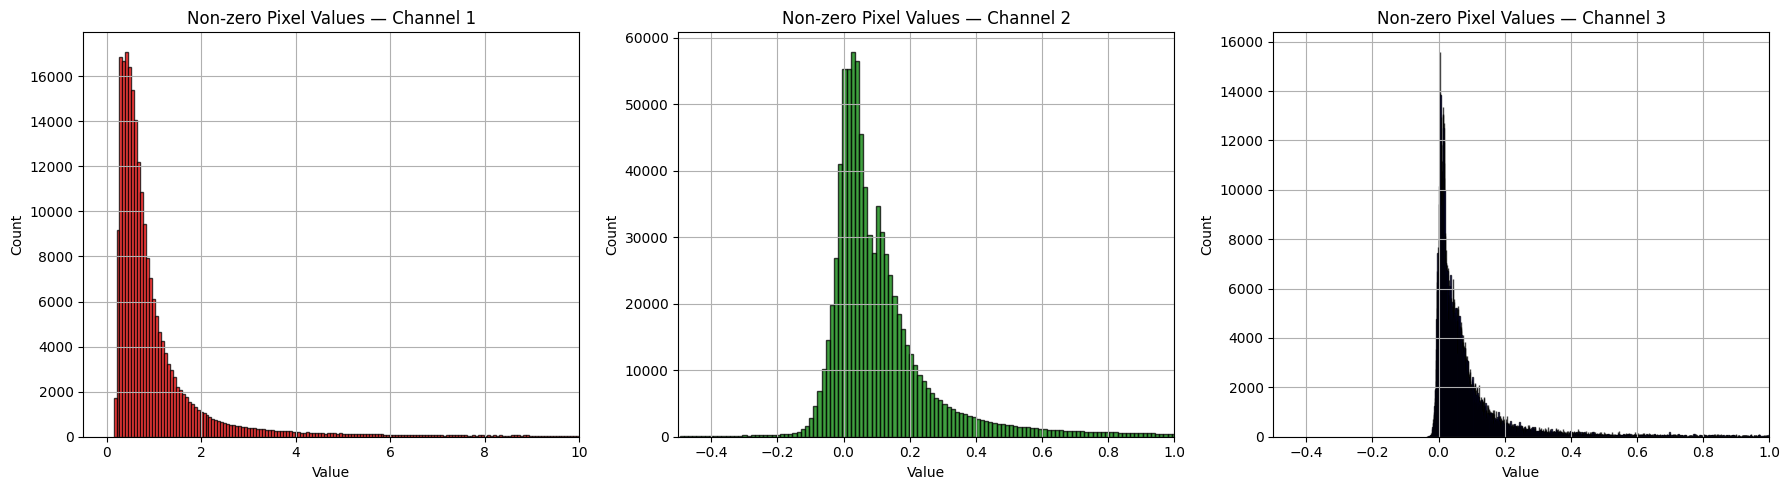

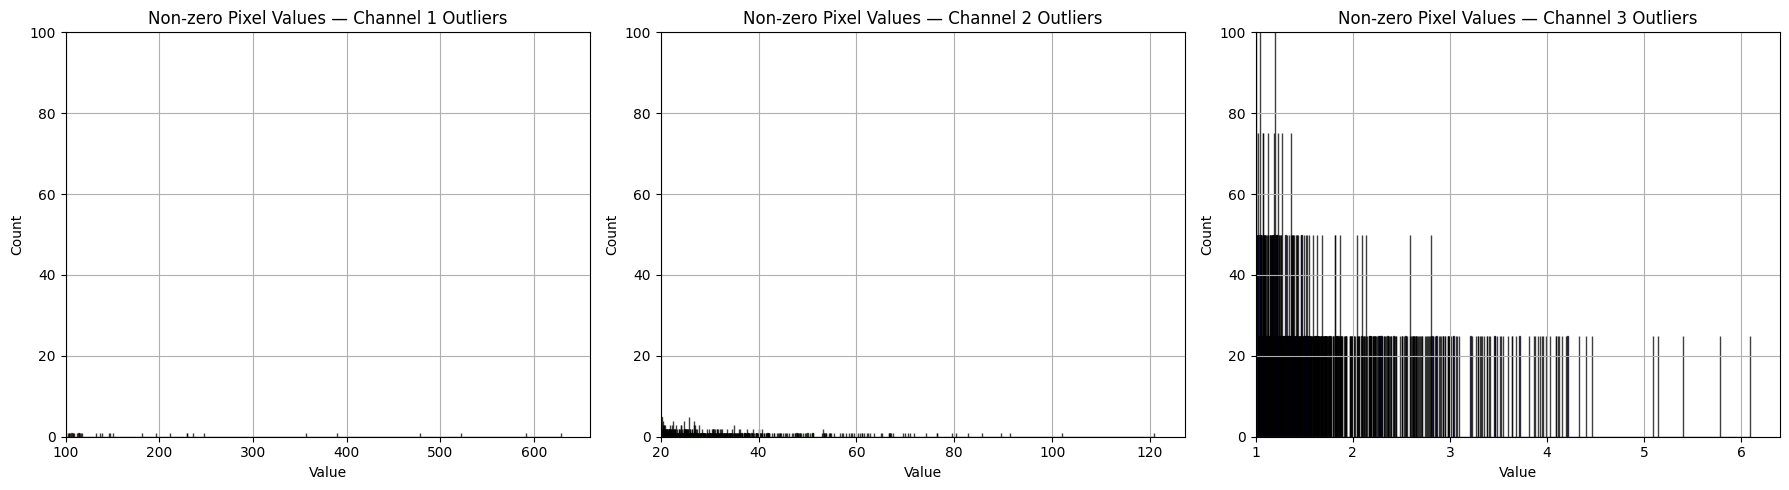

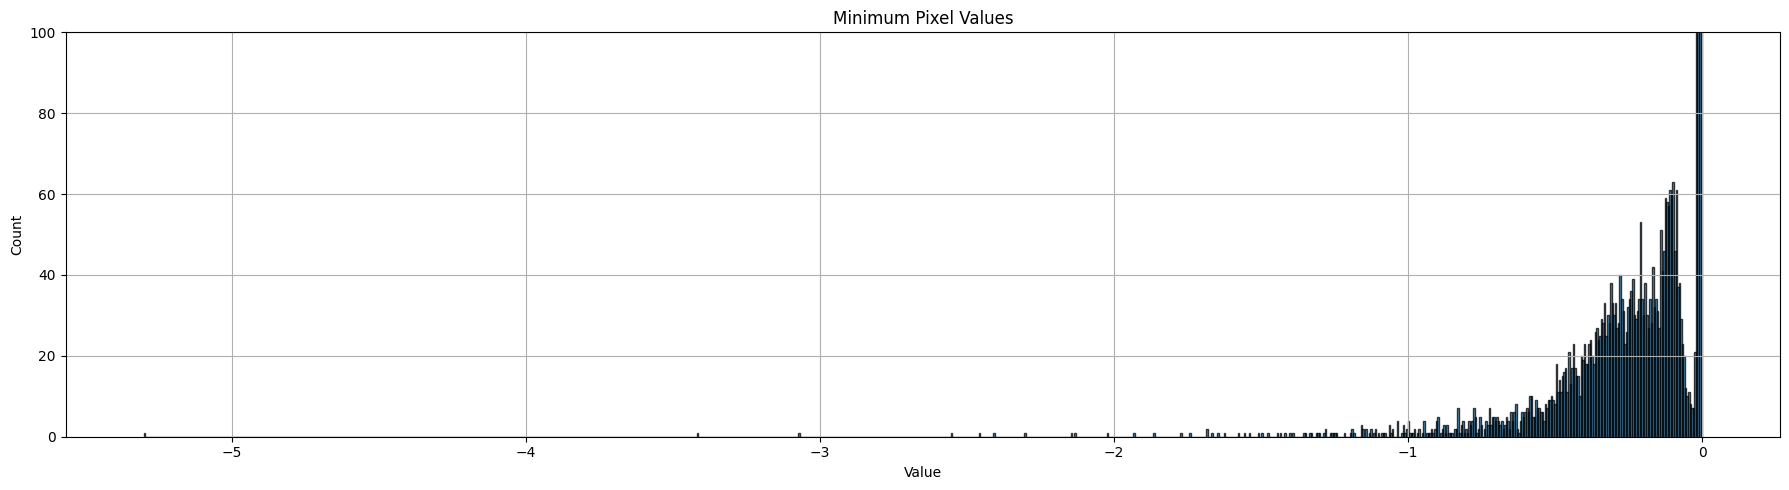

In [25]:
print(quark_gluon_data.keys())
print(quark_gluon_data['X_jets'].shape)
print(quark_gluon_data['m0'].shape)
print(quark_gluon_data['pt'].shape)
print(quark_gluon_data['y'].shape)

plot_data = quark_gluon_data['X_jets'][:3000]
plot_nonzero_pixel_distributions(plot_data)
plot_outlier_pixel_distributions(plot_data)
plot_min_pixel_distributions(plot_data)

In [26]:
plt.imshow(np.swapaxes(dataset.images[500][1,:,:], 0,1), vmin=0, vmax=1)

NameError: name 'dataset' is not defined

In [ ]:
batch_size = 256
n_events = int(.1 * quark_gluon_data['X_jets'].shape[0])

dataset = JetDataset(quark_gluon_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset, bw_method=.2)

# x_max=[1.1, 1, 1, 1, 1, 0.1, 0.1],

In [ ]:
tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

latent_dim = 25*25
lr = 0.00003
n_epochs = 30

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (25, 25)
H, W = (25,25)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0).unsqueeze(0)  # [1, 1, 25, 25]

for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image) in enumerate(dataloader):

        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_img = real_image.cuda()
        real_flipped_img = flipped_image.cuda()

        # Codings should be label, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 5 == 0:
            optimizer_D.zero_grad()

            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            
            fake_flipped_img = torch.flip(fake_img, dims=[-2])  # flip vertically along height (η)
            # print(fake_flipped_feat.shape)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:3]
            fake_disc_codings = z_codings[:,:3]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

            zeros = torch.zeros(2*len(real_pred))
            ones = torch.ones(2*len(fake_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()

            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Generate fake images
            fake_img = generator(z_codings)
            fake_flipped_img = torch.flip(fake_img, dims=[-2])  # flip vertically along height (η)
            fake_disc_codings = z_codings[:,:3]

            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_disc_codings)
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            # ----- Fake ΔR Calculation -----
            # Compute per-image (channel) ΔR stats: output [N, C]
            weights = fake_img

            # Compute per-image (channel) ΔR stats: output [N, C]
            dR = (weights * dists)
            fake_dR_mean = dR.view(batch_size, 3, -1).mean(dim=2)
            fake_dR_std = dR.view(batch_size, 3, -1).std(dim=2)
            
            # Pixel stats: per image channel
            fake_pixel_mean = weights.view(batch_size, 3, -1).mean(dim=2)
            fake_pixel_std = weights.view(batch_size, 3, -1).std(dim=2)

            real_dR_mean = z_codings[:,3:6]
            real_dR_std = z_codings[:,6:9]
            real_pixel_mean = z_codings[:,9:12]
            real_pixel_std = z_codings[:,12:15]

            # Statistical loss

            kl_total = 0
            for c in range(3):
                kl_total += kde_kl_divergence_torch(real_dR_mean[:, c], fake_dR_mean[:, c])
                kl_total += kde_kl_divergence_torch(real_dR_std[:, c], fake_dR_std[:, c])
                kl_total += kde_kl_divergence_torch(real_pixel_mean[:, c], fake_pixel_mean[:, c])
                kl_total += 100* kde_kl_divergence_torch(real_pixel_std[:, c], fake_pixel_std[:, c])

            stat_loss = kl_total
            
            # dR_mean_loss = torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) / batch_size
            # dR_std_loss = torch.nn.MSELoss()(fake_dR_std, real_dR_std) / batch_size
            # pixel_mean_loss = torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) / batch_size
            # pixel_std_loss = torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) / batch_size

            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # Number non-zero loss
            # Count non-zero pixels per image
            # print(fake_img.min())
            # print(real_img.min())
            
            # fake_nnz = (fake_img > 3e-3).float().sum(dim=[1, 2, 3]) /   # Shape: [batch]
            # real_nnz = (real_img > 3e-3).float().sum(dim=[1, 2, 3]) /   # Shape: [batch]
        
            # Compute MSE across batch
            #NNZ_Loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .3
            beta = 30
            chi = 1

            g_loss = (alpha*validity_loss + chi*stat_loss) # + beta*NNZ_Loss

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,3:6].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6:9].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,9:12].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,12:15].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] [Stat_loss: {chi*stat_loss:.4f}]") # [NNZ_loss: {beta*NNZ_Loss:.4f}] 

    z_img = torch.randn(batch_size, 25*25, 1, 1).cuda() 

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, kdes, batch_size=16, latent_dim=625)


plot_metrics(g_losses, d_losses)

# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

layer_colors = {
    'Real': ['blue', 'red', 'green'],
    'Fake': ['cyan', 'salmon', 'lime']
}

fig, axs = plt.subplots(4, 3, figsize=(16, 12))  # 4 stats × 3 layers

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):  # for each statistic
    for col in range(3):  # for each layer
        ax = axs[row, col]

        # Extract per-layer values (assumed shape: [N, 3])
        real_vals = real_stats[row][:, col]
        fake_vals = fake_stats[row][:, col]

        ax.hist(real_vals, bins=200, alpha=0.6, label='Real', color=layer_colors['Real'][col], edgecolor='black')
        ax.hist(fake_vals, bins=200, alpha=0.6, label='Fake', color=layer_colors['Fake'][col], edgecolor='black')
        ax.set_title(f"{stat_titles[row]} — Layer {col + 1}")
        ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Layer and Statistic", fontsize=16, y=1.02)
plt.show()

In [ ]:
n_rows, n_cols = 3, 16
n_images = n_rows * n_cols

vmin = quark_gluon_data['X_jets'][:n_images].min()
vmax = quark_gluon_data['X_jets'][:n_images].max()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, 4.5))
channel_titles = ['Layer 1', 'Layer 2', 'Layer 3']

for b in range(n_cols):
    for c in range(3):
        ax = axes[c, b]
        ax.imshow(dataset.images[-b, c], cmap='viridis')
        ax.axis('off')
        if b == 0:
            ax.set_ylabel(channel_titles[c], fontsize=10)

plt.tight_layout()
plt.suptitle("Reduced Jet Images", fontsize=14, y=1.02)
plt.show()

In [ ]:
def test_generated_samples(generator, kdes, batch_size=4, latent_dim=625, codings = None):
    generator.eval()  # Disable dropout/batchnorm updates

    if codings == None:
        # Latent vectors and codings
        z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        z_codings = torch.cat([
            torch.randint(0, 2, (batch_size, 1)), 
            sample_fit_noise(kdes, num_samples=batch_size)
        ], dim=1).cuda()
    
        with torch.no_grad():
            gen_samples = generator(z_codings).cpu()  # Shape: (B, 3, 25, 25)
    
        print("Generated sample shape:", gen_samples.shape)
        print("Sample feature codings:", np.round(z_codings[:].cpu().numpy(), 4))

    else:
        z_codings = torch.cat(torch.tensor(batch_size), torch.tensor(codings))
        with torch.no_grad():
            gen_samples = generator(z_codings).cpu()  # Shape: (B, 3, 25, 25)
    
        print("Generated sample shape:", gen_samples.shape)
        print("Sample feature codings:", np.round(z_codings[:].cpu().numpy(), 4))

    # Plot: 3 rows (channels) x batch_size columns
    fig, axes = plt.subplots(nrows=3, ncols=batch_size, figsize=(batch_size * 1.5, 4.5))
    channel_titles = ['Layer 1', 'Layer 2', 'Layer 3']

    for b in range(batch_size):
        for c in range(3):
            ax = axes[c, b]
            ax.imshow(gen_samples[b, c].numpy(), cmap='viridis')
            ax.axis('off')
            if b == 0:
                ax.set_ylabel(channel_titles[c], fontsize=10)

    plt.tight_layout()
    plt.suptitle("Generated Jet Images", fontsize=14, y=1.02)
    plt.show()

    generator.train()  # Restore training mode

In [ ]:
test_generated_samples(generator, kdes, batch_size=16, latent_dim=625)